# 2D MT forward modelling with SimPEG

2D modeling can be useful for understanding subsurface electrical resistivity as long as structures are not too complicated.  Here we demonstrate how to build a simple forward model, estimate EM fields, plot, then save for inversion.  

## Learning goals

- Identify Transverse Electric (TE) and Transverse Magnetic (TM) modes.
- Understand how to design mesh. 
- Understand **spatial features** of the transfer function in the form of apparent resistivity and phase
- Explore how the transfer function varies with **frequency**


## Imports

In [3]:
import warnings
import numpy as np

import discretize
from discretize import utils as dis_utils
from SimPEG.electromagnetics import natural_source as nsem
from SimPEG import utils, maps

# here you can choose a solver
from pymatsolver import Pardiso as Solver
from geoana.em.fdem import skin_depth

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib
matplotlib.rcParams['font.size'] = 14

warnings.filterwarnings("ignore")

## Set up Synthetic Data

In [4]:
# station spacing in meters
station_spacing = 4000

# number of stations
n_stations = 26

# station locations and then center them
station_locations = np.arange(n_stations) * station_spacing
station_locations = station_locations - station_locations.mean()

# total distance of station coverage
survey_span = station_locations.max() - station_locations.min()

# make a station array
rx_locs = np.c_[station_locations, np.zeros(n_stations)]

# set frequencies
n_freq = 20
frequencies = np.logspace(-2, 2, n_freq)

# background conductivity
sigma_background = 1E-2


## Step 1: Discretize the domain using a 2D `Tensor` Mesh

Here we create a `discretize.TensorMesh` object from the station locations and modeling frequencies.

<div class="alert alert-block alert-info">
<b> Note: </b> The input into the modeling is the nodes or relative distances between layers and not the actual depth to each layer.  So a simple mesh could be [10, 10, 10, 10].
</div>

<div class="alert alert-block alert-info">
<b> Note: </b> SimPEG assumes a coordinate system where x=East, y=North, z=+up.
</div>

In [5]:
def generate_2d_mesh_for_mt(
    rx_locs,            # station locations
    frequencies,        # frequencies to invert 
    sigma_background,   # background conductivity
    z_factor_max=5,     # maximum factor in vertical direction (factor of skin depth)  
    z_factor_min=5,     # minimum factor in vertical direction (factor of skin depth)
    pfz_down = 1.2,     # geometric factor for increasing cell size in subsurface
    pfz_up = 1.5,       # geometric factor for increasing cell size in air
    npadz_up = 5,       # number of air cells
    x_factor_max = 2,   # maximum factor in horizontal direction
    spacing_factor = 4, # number of cells between stations
    pfx = 1.5,          # geometric factor for increasing cell size in horizontal direction
    n_max=1000          # maximum number of vertical cells
):
    # get minimum cell size (first layer thickness)
    dz_min = np.round(skin_depth(frequencies.max(), sigma_background) / z_factor_max) 
    lz = skin_depth(sigma_background, frequencies.min()) * z_factor_max
    
    # Setting the domain length in subsurface
    for nz_down in range(n_max):
        hz_down = dz_min*pfz_down**np.arange(nz_down)[::-1]
        if hz_down.sum() > lz:
            break
    # create air layers
    hz_up = [(dz_min, npadz_up, pfz_up)]
    hz_up = dis_utils.unpack_widths(hz_up)
    
    # combine air and subsurface
    hz = np.r_[hz_down, hz_up]
    
    # Setting the cells in lateral dimension
    # station spacing
    d_station = np.diff(rx_locs[:,0]).min()
    # minimum cell width
    dx_min = np.round(d_station/spacing_factor)
    # survey span
    lx = rx_locs[:,0].max() - rx_locs[:,0].min()
    ncx = int(lx / dx_min)
    
    # make padding cells
    lx_pad = skin_depth(sigma_background, frequencies.min()) * x_factor_max
    for npadx in range(n_max):
        hx_pad = dis_utils.unpack_widths([(dx_min, npadx, -pfx)])
        if hx_pad.sum()>lx_pad:
            break
    # combine paddin cells with station area cells
    hx = [(dx_min, npadx, -pfx), (dx_min, ncx), (dx_min, npadx, pfx)]  
    
    # make a discretize.TensorMesh object
    mesh = discretize.TensorMesh([hx, hz])
    
    # get the lower left corner of the mesh, the origin
    mesh.origin = np.r_[-mesh.h[0][:npadx].sum()+rx_locs[:,0].min(), -hz_down.sum()]   
    
    print (mesh)
    return mesh

### Create Mesh
Create the mesh from the station locations, frequencies to model, and background conductivity.

In [6]:
mesh = generate_2d_mesh_for_mt(rx_locs, frequencies, sigma_background)


  TensorMesh: 4,720 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    118   -162,330.08    162,330.08  1,000.00 38,443.36    1.50
   y     40   -297,782.46      1,997.91    101.00 49,714.58    1.50




<AxesSubplot: xlabel='x1', ylabel='x2'>

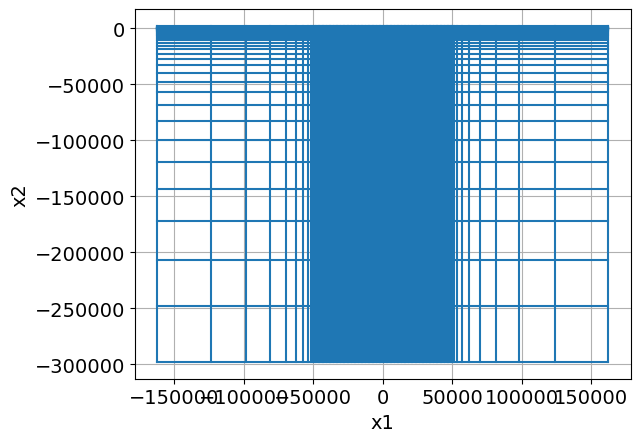

In [7]:
mesh.plot_grid()

## Step 2: Generate a conductivity model

Here we will put a simple conductive block into the center of the model.

In [8]:
# conductivity of the block
sigma_block = 1e0
sigma_air = 1e-8

# create conductivity of subsurface
cells = mesh.cell_centers

# create array of cells with background conductivity
sigma = np.ones(mesh.n_cells) * sigma_background

blk_depth_max = -10000
blk_depth_min = -5000
blk_x_max = 10000
blk_x_min = -10000
blk_ind = utils.model_builder.getIndicesBlock(
    np.r_[blk_depth_max, blk_depth_min],
    np.r_[blk_x_max, blk_x_min],
    cells
)
sigma[blk_ind] = sigma_block
# set air cells above 0
sigma[cells[:, -1] >= 0] = sigma_air

Text(0, 0.5, 'Elevation (m)')

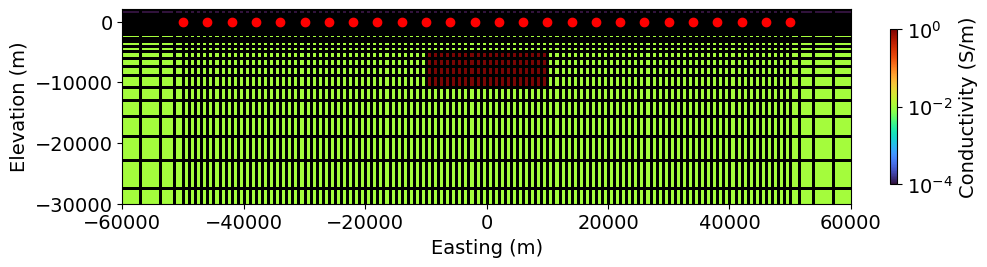

In [9]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
grid= True
out = mesh.plot_image(
    sigma, grid=grid, ax=ax, pcolor_opts={'norm':LogNorm(vmin=1e-4, vmax=1), 'cmap':'turbo'},
    range_x=(-60000, 60000), range_y=(-30000, 2000)
)
ax.plot(rx_locs[:,0], rx_locs[:,1], 'ro')
cb = plt.colorbar(out[0], fraction=0.01)
cb.set_label("Conductivity (S/m)")
ax.set_aspect(1)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Elevation (m)")


## Step 3: Setup `Survey` and `Simulation`

Need to set up the sources and receivers to model.  Here we will model the apparent resistivity and phase of each mode TE and TM.  Remember TE is where the electric field is parallel to electric strike which should be perpendicular to the profile being modeled.  Therefore the TE mode should have the electric field perpendicular to the profile being modeled. TM has an electric field parallel to the profile.    

<div class="alert alert-block alert-warning">
<b>Important:</b> SimPEG assumes TE mode is yx and TM is xy, not positive why yet. I think because x is assumed to be parallel with the profile so Ex/Hy would be E-parallel with the profile and H-perpendicular to the profile. Need to check.
</div>

In [10]:
## simulation class for TM mode
# create receivers for TM mode
rx_list_tm = [
    nsem.receivers.PointNaturalSource(
        rx_locs, orientation="xy", component="apparent_resistivity"
    ),
    nsem.receivers.PointNaturalSource(
        rx_locs, orientation="xy", component="phase"
    ),
]
# create source list for TM mode
src_list_tm = [nsem.sources.Planewave(rx_list_tm, frequency=f) for f in frequencies]
survey_tm = nsem.Survey(src_list_tm)

# create a simulation class that will estimate Electric fields
sim_tm= nsem.simulation.Simulation2DElectricField(
    mesh,
    survey=survey_tm,
    sigma=sigma,
    solver=Solver,
)

# simulation class for TE mode
rx_list_te = [
    nsem.receivers.PointNaturalSource(
        rx_locs, orientation="yx", component="apparent_resistivity"
    ),
    nsem.receivers.PointNaturalSource(
        rx_locs, orientation="yx", component="phase",        
    ),       
]
src_list_te = [nsem.sources.Planewave(rx_list_te, frequency=f) for f in frequencies]
survey_te = nsem.Survey(src_list_te)

sim_te = nsem.simulation.Simulation2DMagneticField(
    mesh,
    survey=survey_te,
    sigma=sigma,
    solver=Solver,
)

## Step 4: Run forward modelling

In [ ]:
%%time
forward_te = sim_te.fields()
predicted_te = sim_te.dpred(f=forward_te)
forward_tm = sim_tm.fields()
predicted_tm = sim_tm.dpred(f=forward_tm)

In [ ]:
# extract fields for the first frequency
i_freq = 0 
e_te = forward_te[src_list_te[i_freq], 'e']
h_te = forward_te[src_list_te[i_freq], 'h']
e_tm = forward_tm[src_list_tm[i_freq], 'e']
h_tm = forward_tm[src_list_tm[i_freq], 'h']

In [ ]:
xlim = (-60000, 60000)
ylim = (-30000, 0)

fig = plt.figure(11, figsize=(24, 10))

## TM Electric field vectors
ax_tm_e = fig.add_subplot(4, 1, 1)
out = mesh.plot_image(e_tm.real, v_type='E', view='vec', ax=ax_tm_e, range_x=xlim, range_y=ylim)
cb = plt.colorbar(out[0], fraction=0.01, ax=ax_tm_e)
cb.set_label("TM Electric Field")

## TM magnetic field
ax_tm_h = fig.add_subplot(4, 1, 2)
out = mesh.plot_image(
    h_tm.real, v_type='CC', ax=ax_tm_h, range_x=xlim, range_y=ylim,
    pcolor_opts={'cmap':'plasma'}
)
cb = plt.colorbar(out[0], fraction=0.01, ax=ax_tm_h)
cb.set_label("TM Magnetic Field")

## TE Electric Field
ax_te_e = fig.add_subplot(4, 1, 3)
out = mesh.plot_image(e_te.real, v_type='CC', ax=ax_te_e, range_x=xlim, range_y=ylim)
cb = plt.colorbar(out[0], fraction=0.01, ax=ax_te_e)
cb.set_label("TE Electric Field")

ax_te_h = fig.add_subplot(4, 1, 4)
out = mesh.plot_image(
    h_te.real, v_type='E', view='vec', ax=ax_te_h, range_x=xlim, range_y=ylim,
    pcolor_opts={'cmap':'plasma'}, stream_opts={'color':'w'}
)
cb = plt.colorbar(out[0], fraction=0.01, ax=ax_te_h)
cb.set_label("TE Magnetic Field")

for ax in [ax_tm_e, ax_tm_h, ax_te_e, ax_te_h]:
    ax.set_aspect(1)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Elevation (m)")

In [ ]:
PRED_te = predicted_te.reshape((n_freq, 2, n_stations))
PRED_tm = predicted_tm.reshape((n_freq, 2, n_stations))

rho_app_te = PRED_te[:,0,:]
rho_app_tm = PRED_tm[:,0,:]

phase_te = PRED_te[:,1,:]
phase_tm = PRED_tm[:,1,:]

In [ ]:
from ipywidgets import widgets, interact

In [ ]:
import matplotlib
matplotlib.rcParams['font.size'] = 12
def foo_te(kk, mode):
    fig, axs = plt.subplots(2, 1, figsize=(8, 5))
    for i_freq in range(kk):
        ax1, ax2 = axs
        if mode == 'TE':
            ax1.semilogy(rx_locs[:,0], rho_app_te[i_freq,:], '-', label='TE-AppRes.', color='C0')
            ax2.plot(rx_locs[:,0], phase_te[i_freq,:], '-', label='TE-Pha.', color='C0')
        elif mode == 'TM':
            ax1.semilogy(rx_locs[:,0], rho_app_tm[i_freq,:], '-', label='TM-AppRes.', color='C1')
            ax2.plot(rx_locs[:,0], phase_tm[i_freq,:]+180, '-', label='TM-Pha.', color='C1')
        ax1.set_title("Frequency at {:.1e} Hz".format(frequencies[i_freq]))
        ax1.set_xticklabels([])
        ax1.set_ylim(1, 1e3) 
        ax2.set_ylim(0, 90)
        ax1.set_ylabel("Apparent resistivity (Ohm-m)")
        ax2.set_ylabel("Phase (degree)")

In [ ]:
interact(
    foo_te, 
    kk=widgets.IntSlider(min=1, max=len(frequencies), value=1, continuous_update=True),
    mode=widgets.RadioButtons(options=['TE', 'TM'])
)

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
i_freq = 0
ax1.plot(rx_locs[:,0], rho_app_te[i_freq,:], '-', label='TE-AppRes.', color='C0')
ax1.plot(rx_locs[:,0], rho_app_tm[i_freq,:], '-', label='TM-AppRes.', color='C1')
# ax1.set_ylim(50, 2e2) 
ax1.legend()

In [ ]:
i_sounding = 3
fig, axs = plt.subplots(2, 1, figsize=(8, 6))
ax1, ax2 = axs
ax1.loglog(1./frequencies, rho_app_te[:,i_sounding], '.-', label='TE-AppRes.')
ax1.loglog(1./frequencies, rho_app_tm[:,i_sounding], '.-', label='TM-AppRes.')
ax1.legend()
ax1.set_ylim(1, 1e4)

ax2.semilogx(1./frequencies, phase_te[:,i_sounding], '.-', label='TE-Pha.')
ax2.semilogx(1./frequencies, phase_tm[:,i_sounding]+180, '.-', label='TM-Pha.')
ax2.set_ylim(0, 90)
ax2.legend()
for ax in axs:
    ax.grid(True, which='both', alpha=0.3)
ax1.set_ylabel("Resistivity (Ohm-m)")
ax2.set_ylabel("Phase (degree)")
ax2.set_xlabel('Period (s)')

In [ ]:
noise_rho_app_te = 0.05 * abs(rho_app_te) * np.random.randn(n_freq, n_stations)
noise_rho_app_tm = 0.05 * abs(rho_app_tm) * np.random.randn(n_freq, n_stations)
noise_phase_te = 2 * np.ones_like(phase_te) * np.random.randn(n_freq, n_stations)
noise_phase_tm = 2 * np.ones_like(phase_tm) * np.random.randn(n_freq, n_stations)

## Step 5: Create `MTpy` object and save as `MTH5` format

In [ ]:
output_results ={
    'rx_locs': rx_locs,
    'frequencies': frequencies,
    'app_rho_te': rho_app_te+noise_rho_app_te,
    'app_rho_tm': rho_app_tm+noise_rho_app_tm,
    'phase_te': phase_te+noise_phase_te,
    'phase_tm': phase_tm+noise_phase_tm,
    'mesh': mesh,
    'sigma': sigma
}

In [ ]:
from pathlib import Path
import numpy as np
from mtpy import MTCollection
from mtpy import MT
from mtpy.core.transfer_function.z import Z

with MTCollection() as mc:
    mc.open_collection(filename=Path().cwd().joinpath("mt_examples", "notebooks", "simpeg", "2d_forward_mth5.h5"))
    for i_rx in range(n_stations):
        app_rho_matrix = np.zeros((n_freq, 2, 2), dtype=float)
        phase_matrix = np.zeros((n_freq, 2, 2), dtype=float)
        app_rho_matrix[:,0,1] = output_results['app_rho_te'][:,i_rx]
        app_rho_matrix[:,1,0] = output_results['app_rho_tm'][:,i_rx]
        phase_matrix[:,0,1] = output_results['phase_te'][:,i_rx]
        phase_matrix[:,1,0] = output_results['phase_tm'][:,i_rx]
        # or add apparent resistivity and phase
        z_object = Z(frequency=frequencies)
        z_object.set_resistivity_phase(app_rho_matrix, phase_matrix, frequencies)

        dx_lon = station_spacing / 1e5

        response = MT()  
        response.Z = z_object

        response.survey_metadata.id = "model_2d_response"
        response.station_metadata.id = f"mt-{i_rx:d}"
        response.station_metadata.transfer_function.id = f"mt-{i_rx:d}"
        # if this is 2D maybe we need a location
        response.station_metadata.location.latitude = 40 
        response.station_metadata.location.longitude = -122 + dx_lon * (i_rx)
        mc.add_tf(response)

In [ ]:
mc.mth5_collection.filename

In [ ]:
output_results["app_rho_te"][:, -1]

In [ ]:
output_results["rx_locs"][0]

In [ ]:
response.plot_mt_response()